# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

# Section 0: Initial data exploration

## 0.1 Loading the data
Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple function to load in text files containing the transcripts, figure out who the speakers are, and separate the text blocks into a list of words.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
import mysql.connector
import re
from sklearn.preprocessing import QuantileTransformer
import time
import matplotlib.cm as cm

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}

plt.rc('font', **font)

Using TensorFlow backend.


In [2]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [3]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

In [4]:
num_transcripts = 4131
transcript_df = pull_transcript(n=num_transcripts)

In [5]:
# We want to go ahead and split the tables into testing and training sets, so that we don't over-fit. 
np.random.seed(42)
transcript_df['train'] = np.random.rand(num_transcripts)>.2

# divide into two data structures
test_transcript_df = transcript_df.loc[transcript_df.train==False,:]
train_transcript_df = transcript_df.loc[transcript_df.train,:]

In [6]:
# Further separate the training dataset into a training and validation set
train_transcript_df.loc[:,'val'] = np.random.rand(train_transcript_df.shape[0])>.8
val_transcript_df = train_transcript_df.loc[train_transcript_df.val,:]

train_transcript_df = train_transcript_df.loc[train_transcript_df.val==False,:]

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 0.2 Example transcript

Let's print a little bit of the transcript from the first dataset, and see what it looks like.

In [7]:
print(train_transcript_df.loc[1,'transcript'][:500])


    
        
    

    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).
    (LAUGHTER)
    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.
    PETER SAGAL, HOST: 
    Thank you, Bill. Thank you, everybody.
    (CHEERING)
    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to M


In [8]:
train_transcript_df.loc[1,'transcript'][:1000]

"\n    \n        \n    \n\n    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).\n    (LAUGHTER)\n    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.\n    PETER SAGAL, HOST: \n    Thank you, Bill. Thank you, everybody.\n    (CHEERING)\n    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to Microsoft co-founder Steve Ballmer. He is, we believe, the richest guest we've ever had. But, of course, your true wealth is measured in your friends. And this just in - he has more friends, too.\n    (LAUGHTER)\n    SAGAL: But first, as many of you know, the NPR podcast feeds got all screwed up last week. People who tried to download our show got, for example, How I Built This instead, for which I apologize. And the people who wanted How I Built This got us, for which I apologize eve

Initially, we can note a number of features. First, audience responses are noted with the '(LAUGHTER)' marker and '(APPLAUSE)' marker. This will prove very useful, as we have an automatic metric for "funniness" of the preceding text. 

Speakers' names are in all caps, followed by a colon. Speakers are also separated by a line break and a tab, which could potentially be used to segment the text into phrases by various people. 

It's probably worth doing a little more processing on these lines, dividing them by speaker, and giving them a marker for applause and laughter if they are followed by applause or laughter. 

In [9]:
def line_info(transcript_numbers):
    
    # extract the transcript, and divide it by lines
    transcript = transcript_df.loc[transcript_numbers,'transcript'].str.cat();
    by_lines = transcript.split('\n    ')
    df = pd.DataFrame(by_lines,columns=['lines']) # turn the lines into a dataframe
    
    # if the line contains "LAUGHTER", mark the previous line as "funny"
    df['funny'] = df['lines'].str.contains('LAUGHTER')
    df['funny'] = df.funny.shift(-1) # need funny to modify the previous line
    
    # if the line contains "APPLAUSE", mark the previous line as "clapping"
    df['clapping'] = df['lines'].str.contains('APPLAUSE')
    df['clapping'] = df['lines'].str.contains('CLAPPING')
    df['clapping'] = df['lines'].str.contains('CHEERING')
    df['clapping'] = df.clapping.shift(-1)

    # for the remaining lines, identify the speaker using regular expressions
    df['speaker'] = df['lines'].str.extract(r'([A-Z]+:)',expand=False).str.replace(r':','')
    df['lines'] = df['lines'].str.replace(r'.+?(?=:)','').str.replace(r':','')
    df['speaker'] = df['speaker'].str.replace('JR','BLOUNT') # disambiguating Roy Blount Jr
    df['speaker'] = df['speaker'].str.replace('HOST','SAGAL') # sometimes refers to Sagal as host
    # NOTE: There's some weird formatting with Peter Sagal's first line, 
    # where it calls him "Host" and puts his statement on the next line. It's not a huge thing,
    # so I'm leaving it for now, but might be worth coming back to later.
    
    # drop the lines with no speaker (Applause markers, empty lines, etc.)
    df = df.dropna()
    
    # Create a column with the number of separated words
    df['num_words'] = df.lines.str.split().str.len()
    
    # Normalize the number of words with a quantile transformer
    QT = QuantileTransformer(n_quantiles=1000,output_distribution='uniform')
    QT.fit(df.num_words.values.reshape(-1,1)) 
    df['uniform_words'] = QT.transform(df.num_words.values.reshape(-1,1))
    
    # Create a column with whether the previous line was funny (for predictions)
    df['prev_line_funny'] = df.funny.shift(1)

    return df

In [10]:
# Process the training set and show the top of the dataframe
lines_df = line_info(train_transcript_df.index)
full_lines_df = line_info(transcript_df.index)
val_lines_df = line_info(val_transcript_df.index)
lines_df.head()

,lines,funny,clapping,speaker,num_words,uniform_words,prev_line_funny
4,"From NPR and WBEZ Chicago, this is WAIT WAIT....",True,False,KURTIS,25,8.353353e-01,NaN
6,I'm Bill Kurtis. And here's your host at the ...,False,False,KURTIS,17,7.357357e-01,True
7,,False,False,SAGAL,0,1.000000e-07,False
10,Thank you so much. We have a very interesting...,True,False,SAGAL,56,9.649650e-01,False
12,"But first, as many of you know, the NPR podca...",True,False,SAGAL,53,9.594595e-01,True


NameError: name 'transcript' is not defined

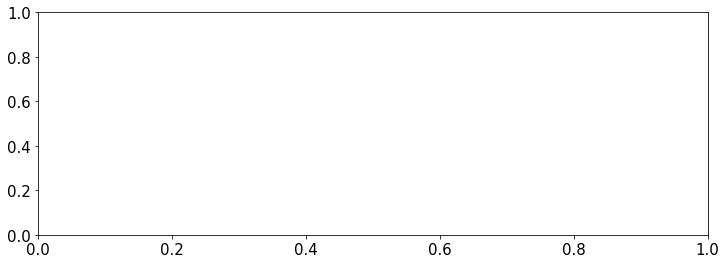

In [12]:
plt.figure(figsize=(12,9))
plt.subplot(2,1,1);
plt.hist(transcript.num_words);
plt.xlabel('Line length')
plt.ylabel('Frequency')

plt.subplot(2,1,2);
plt.plot(transcript.clapping)
plt.plot(transcript.funny);
plt.xlabel('Line number')
plt.ylabel('Response')
plt.legend(['applause','laughter'],loc='upper right')

## 0.3 Word cloud
Just for fun, let's make a "word cloud" - this is a visualization tool that makes a pretty picture, with word sizes based on their frequency in the text. I based the formatting on this on the excellent tutorial by Max Woolf, posted [here](https://minimaxir.com/2016/05/wordclouds/). I'll make the picture in shades of orange, and in the shape of an exclamation point, in line with the logo of Wait Wait.

In [147]:
from wordcloud import WordCloud, STOPWORDS
import string
from palettable.colorbrewer.sequential import Oranges_9
import random
from PIL import Image

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Oranges_9.colors[random.randint(3,8)])

font_path = './Fonts/AmaticSC-Bold.ttf' # font from google fonts: https://fonts.google.com/?selection.family=AmaticSC

In [14]:
# concatenate the text from all of the transcripts
text = train_transcript_df.transcript.str.cat()

# convert everything to upper case so we don't get repeat counts
text = text.upper()

# remove the footer text at the bottom of each transcript
copyright_text = text[-475:]
stopwords = set(STOPWORDS)
stopwords = stopwords.union(set(copyright_text.split()))

In [15]:
# load the image mask: exclamation inside a circle from fontawesome
icon_path = './exclamation-sign.png'
icon = Image.open(icon_path)
icon = np.array(icon)

In [16]:
# generate the word cloud
wc = WordCloud(background_color="white", 
               font_path=font_path,
               collocations=False,
               max_words=1000,
               max_font_size=240, 
               random_state=42,
               mask=icon,
               stopwords=stopwords,
               color_func=color_func)
               
# generate word cloud
wc.generate_from_text(text.upper());

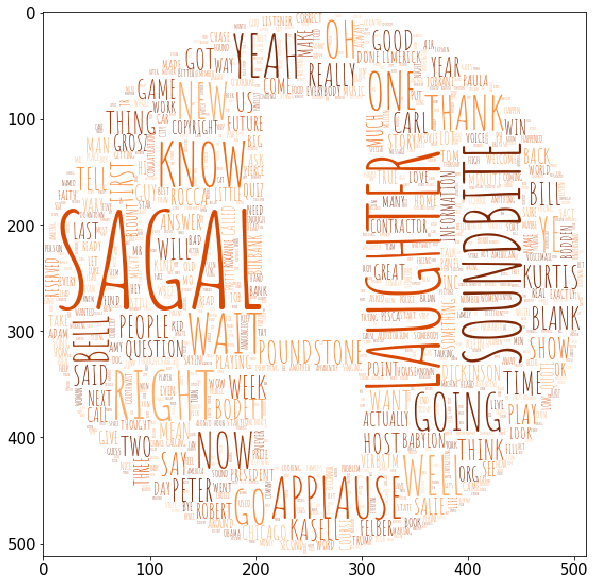

In [20]:
# plot the cloud
plt.figure(figsize=(10,10));
plt.imshow(wc);

# uncomment this to save the image
# wc.to_file("WaitWaitCloud-big.png");

# Speakers vs time

In [11]:
# Use the segment "Predictions" to get the panelists, as this segment typically does not involve guests or call-ins
predictions_df = transcript_df.loc[transcript_df.segment=='predictions'] # Get speaker info for 

# Separate the year from the airdate
years = pd.to_datetime(predictions_df['aired_at']).dt.year
predictions_df.loc[:,'year'] = years

# from the transcripts, extract the unique speakers, 
# representing the host (typically Sagal), scorekeeper (Kassel/Curtis) and panelists
speakers = predictions_df.transcript.str.extractall(r'([A-Z]+:)') # Caps followed by ":" denotes a speaker
speakers.iloc[:,0] = speakers.iloc[:,0].str.replace(r':','') # remove trailing colon
speakers.iloc[:,0] = speakers.iloc[:,0].str.replace(r'JR','BLOUNT') # correcting error with roy blount, jr.
unique_speakers = speakers.groupby('id').apply(np.unique) # find the unique names
unique_speakers = pd.DataFrame(unique_speakers,columns=['unique_speakers']) # make into a dataframe

# Add unique speakers to the predictions database
speakers_by_year_df = unique_speakers.join(predictions_df.loc[:,['year']]) 

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
# For each year, count the number of episodes each panelist was in
for i, year in enumerate(np.unique(speakers_by_year_df.year.values)):
    speaker_list = np.concatenate(speakers_by_year_df.loc[speakers_by_year_df.year==year,'unique_speakers'].values)
    counts = np.array(np.unique(speaker_list,return_counts=True)).T
    if i ==0: # initialize the dataframe on the first year
        count_df = pd.DataFrame(data = counts[:,1],index=counts[:,0],columns=[str(year)])
    else:
        count_df = count_df.join(pd.DataFrame(data = counts[:,1],index=counts[:,0],columns=[str(year)]),how='outer')

# If a speaker didn't appear in a given year, then give that entry a zero
count_df.fillna(0,inplace=True)

# Remove the years where we don't have all of the transcripts
count_df.drop(['2010','2019'],axis=1,inplace=True)

# Remove speakers who appear very rarely
count_df.drop(count_df.index[count_df.sum(axis=1)<=5],inplace=True)

# Remove non-panelists 
count_df.drop(['HOST','SAGAL','PESCA','KURTIS','KASELL','BYLINE','O'],inplace=True)
# count_df.drop(['HOST','BYLINE','O'],inplace=True)


# order the count by when the speaker's biggest number is
count_df.loc[:,'best_year'] = np.argmax(count_df.values/np.sum(count_df.values,axis=0),axis=1)
count_df.sort_values('best_year',inplace=True,ascending=True)
count_df.drop(['best_year'],axis=1,inplace=True)


# Show the counts
count_df

,2011,2012,2013,2014,2015,2016,2017,2018
BLOUNT,11,4,2,1,0,2,5,2
POUNDSTONE,16,13,12,13,13,12,12,12
BODETT,13,12,13,12,11,10,11,5
PIERCE,10,9,8,6,3,0,0,0
BABYLON,8,14,11,10,8,3,2,3
KLEIN,3,6,3,4,1,1,1,2
CONNOR,3,11,13,9,1,0,0,0
GOLDTHWAIT,0,2,5,2,1,4,0,1
FELBER,7,6,7,9,8,8,6,7
FERO,0,0,0,5,0,2,0,0


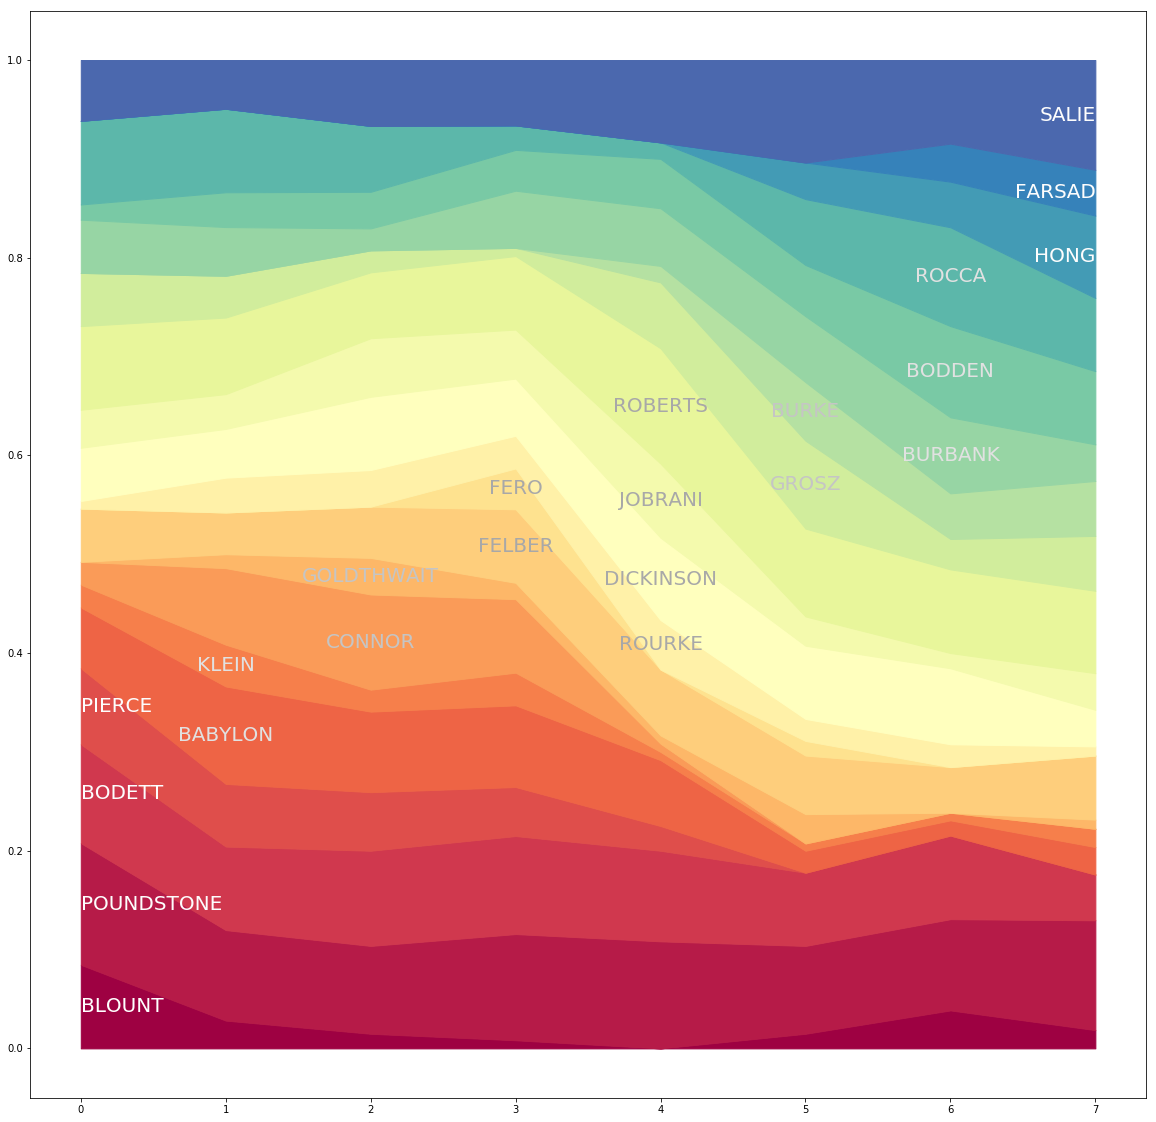

In [23]:

# Normalize count by the number of total panelists per year
frequencies = np.cumsum(count_df)/np.sum(count_df)

plt.figure(figsize=(20,20))

# Initialize some stuff for plotting the labels
colormap = cm.Spectral
txt_x = 0.5
stepsize = 6/frequencies.shape[0]
text_color = [.8,.8,.8]

# Fill in the first entry manually
plt.fill_between(range(8),frequencies.iloc[0,:],color=colormap(0))
txt_x = 0
txt_y = frequencies.iloc[0,txt_x]/2 #hacky
text_color = np.array([1, 1, 1])
label = frequencies.index[0]
plt.text(txt_x,txt_y,label,ha='left',va='center',color=text_color,fontsize=20)

# Loop through the remaining entries
for i in range(frequencies.shape[0]-1):
    t = plt.fill_between(range(8),frequencies.iloc[i,:],frequencies.iloc[i+1,:],color=colormap((i+1)/frequencies.shape[0]))
    
    # label the speaker
    txt_x = np.argmax(frequencies.iloc[i+1,:].values-frequencies.iloc[i,:].values)
    txt_y =np.mean(frequencies.iloc[[i,i+1],txt_x])
    text_color = ((np.abs(3.5-txt_x))-.5)/9+.66*np.array([1, 1, 1]) # shift text color so it shows up
    label = frequencies.index[i+1]
    if txt_x==0:
        plt.text(txt_x,txt_y,label,ha='left',va='center',color=text_color,fontsize=20)
    elif txt_x==7:
        plt.text(txt_x,txt_y,label,ha='right',va='center',color=text_color,fontsize=20)
    else:
        plt.text(txt_x,txt_y,label,ha='center',va='center',color=text_color,fontsize=20)

# uncomment this to save the image
plt.savefig('Panelists_vs_time.png', dpi=None, facecolor='None', edgecolor='None',
              orientation='portrait', format='png',
              transparent=True, bbox_inches=0, pad_inches=0,
              frameon=None)

# Section 1: Understanding jokes

### 1.1 Who is the funniest panelist? 

The first question I address is which panelist is the funniest. I'm aided in this process by the fact that laughter is marked in the transcripts, with the label "(LAUGHTER)". Thus, I can look at every laugh, and figure out who caused it. But people who talk more are likely to get more laughs than those who don't talk much, on average. So, I will calculate the "**Laugh rate**," defined as the number of laughs each speaker gets per statement. It can also be the probability of laughter, given something the panelist said. I will save my results in a pandas table.

In [37]:
# generate an empty pandas dataframe to keep track of the results
speaker_df = pd.DataFrame(index=[], columns=['num_lines','num_laughs','num_claps'])
speaker_df = speaker_df.fillna(0)

# add all speakers to the dataframe
for speaker in set(full_lines_df.speaker):
        speaker_df.loc[speaker,:] = 0

# Count the number of laughs each speaker receives
funny_counts = full_lines_df.loc[full_lines_df['funny'],'speaker'].value_counts()
speaker_df.loc[funny_counts.index,'num_laughs'] +=funny_counts

# Count the number of claps each speaker receives
clap_counts = full_lines_df.loc[full_lines_df['clapping'],'speaker'].value_counts()
speaker_df.loc[clap_counts.index,'num_claps'] +=clap_counts

# Count the number of lines per speaker
line_counts = full_lines_df.loc[:,'speaker'].value_counts()
speaker_df.loc[line_counts.index,'num_lines'] += line_counts

# Remove speakers that we didn't select in the previous section (one-off guests, call ins, and rare panelists)
speaker_df = speaker_df.loc[count_df.index,:]

In [38]:
speaker_df.head()

,num_lines,num_laughs,num_claps
BLOUNT,1734.0,486.0,0.0
POUNDSTONE,9868.0,2972.0,4.0
BODETT,5474.0,1303.0,0.0
PIERCE,1855.0,416.0,0.0
BABYLON,4020.0,1003.0,0.0


In [39]:
speaker_df.describe() # some summary statistics on the data

,num_lines,num_laughs,num_claps
count,22.000000,22.000000,22.000000
mean,3212.227273,763.772727,2.318182
std,2207.409081,609.027791,2.982271
min,311.000000,53.000000,0.000000
25%,1737.500000,422.500000,0.000000
50%,2604.500000,573.500000,1.500000
75%,4834.500000,991.250000,4.000000
max,9868.000000,2972.000000,11.000000


Text(0,0.5,'# panelists')

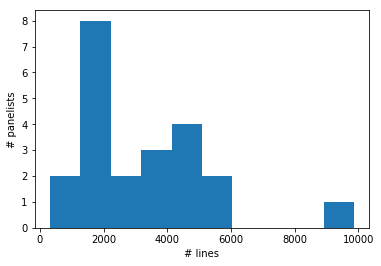

In [40]:
plt.hist(speaker_df.num_lines);
plt.xlabel('# lines')
plt.ylabel('# panelists')

In [41]:
# Now divide the number of laughs by the number of words to get the laugh rate (laughs per hundred words)
speaker_df['laughs_per_line'] = speaker_df['num_laughs']/speaker_df['num_lines']
speaker_df['clap_rate'] = speaker_df['num_claps']/speaker_df['num_lines']
speaker_df.sort_values('laughs_per_line',ascending=False)

,num_lines,num_laughs,num_claps,laughs_per_line,clap_rate
GOLDTHWAIT,1272.0,455.0,0.0,0.357704,0.000000
BURKE,1322.0,427.0,0.0,0.322995,0.000000
POUNDSTONE,9868.0,2972.0,4.0,0.301176,0.000405
BLOUNT,1734.0,486.0,0.0,0.280277,0.000000
BODDEN,2688.0,749.0,8.0,0.278646,0.002976
BURBANK,3480.0,956.0,2.0,0.274713,0.000575
FARSAD,674.0,180.0,1.0,0.267062,0.001484
BABYLON,4020.0,1003.0,0.0,0.249502,0.000000
KLEIN,1748.0,435.0,5.0,0.248856,0.002860
ROCCA,5395.0,1325.0,4.0,0.245598,0.000741


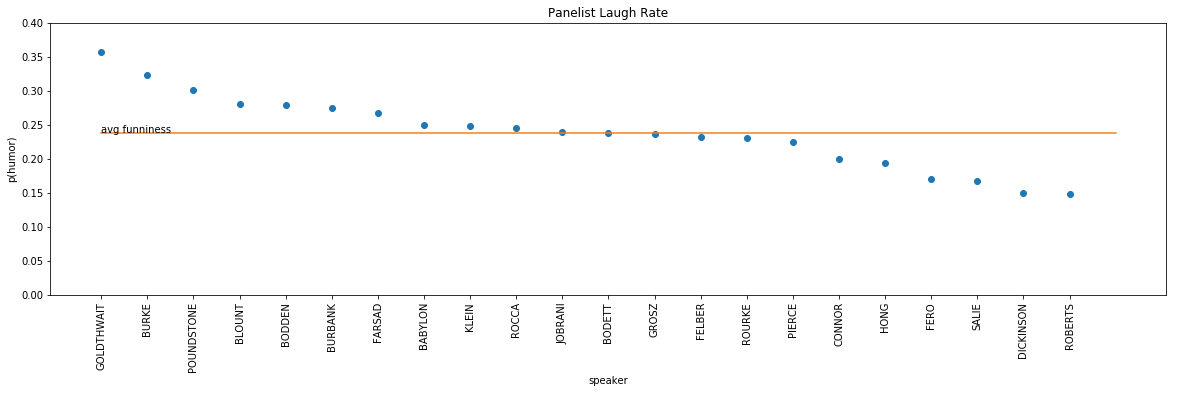

In [42]:
plt.figure(figsize=(20,5));
mean_funniness = speaker_df.num_laughs.sum()/speaker_df.num_lines.sum() # average laugh rate over all panelists
plt.plot(speaker_df.sort_values('laughs_per_line',ascending=False).laughs_per_line,'o');
plt.plot([0, speaker_df.shape[0]],[mean_funniness,mean_funniness]) # average line funniness
plt.text(0,mean_funniness,'avg funniness')

plt.xlabel('speaker');
plt.xticks(rotation=90);
plt.ylabel('p(humor)');
plt.ylim([0, .4]);
plt.title('Panelist Laugh Rate');
plt.savefig('Panelist_laugh_rate.svg',dpi=150)

## 1.2 Panelist word frequencies
TF-IDF (Term Frequency-inverse document frequency) is a technique from natural language processing in which the frequency of words is compared between different "documents" (or blocks of text). Words are considered important for a given document if they occur much more frequently compared with the others.

I will apply this method to blocks of text from all panelists, to see if there are topics or words that are more common for some panelists than others.

In [48]:
# Join together all lines said by each panelist
for speaker in speaker_df.index:
    speaker_df.loc[speaker,'lines'] = lines_df.loc[lines_df.speaker==speaker,'lines'].str.cat()
speaker_df.head()

,num_lines,num_laughs,num_claps,laughs_per_line,clap_rate,lines
BLOUNT,1734.0,486.0,0.0,0.280277,0.000000,Volleyball is what nudists play. It's a big n...
POUNDSTONE,9868.0,2972.0,4.0,0.301176,0.000405,"Wow. Do you know I was on ""Jeopardy"" once? I ..."
BODETT,5474.0,1303.0,0.0,0.238034,0.000000,Did he sniff his head? When Carol Dahmen of S...
PIERCE,1855.0,416.0,0.0,0.224259,0.000000,(Singing) He's in the jailhouse now. He's in ...
BABYLON,4020.0,1003.0,0.0,0.249502,0.000000,"It would have - it would have to be, like, a ..."


In [90]:
# Thanks to https://stackoverflow.com/questions/34449127/sklearn-tfidf-transformer-how-to-get-tf-idf-values-of-given-words-in-documen
from sklearn.feature_extraction.text import TfidfVectorizer

# Function that takes in a dataframe and calculates the TF/IDF of the "lines" column, 
# returning the top-scoring words for each row
def Calc_top_words(input_dataframe,num_words=5,max_df=.8,min_df=.2):
    # Train word frequencies on the inputs
    tfidf = TfidfVectorizer(max_df=max_df,min_df = min_df) # exclude words that appear too often or too rarely
    tfidf_matrix =  tfidf.fit_transform(input_dataframe.lines)
    feature_names = tfidf.get_feature_names()

    # Extract the features by speaker
    word_df = pd.DataFrame(tfidf_matrix.toarray().T, index = tfidf.get_feature_names(),columns = input_dataframe.index)
    for speaker in input_dataframe.index:
        words = word_df.sort_values(speaker,ascending=False).head(num_words).index.values
        input_dataframe.loc[speaker,'top_words'] = ', '.join(words)

    # order speakers alphabetically
    input_dataframe.sort_index(inplace=True)

    # display the top words
    return pd.DataFrame(input_dataframe.top_words)

Calc_top_words(speaker_df)


,top_words
BABYLON,"yep, whoa, hold, drugs, curious"
BLOUNT,"mice, memory, bump, sea, chickens"
BODDEN,"kardashian, gm, swim, wendy, viagra"
BODETT,"yoga, carl, aaron, shannon, jim"
BURBANK,"river, event, radio, ramen, basically"
BURKE,"ha, cans, reveal, resume, michigan"
CONNOR,"heels, gaga, liz, position, park"
DICKINSON,"whoa, litter, nuclear, kitty, tower"
FARSAD,"shadow, curtain, jump, property, boyfriend"
FELBER,"appearance, pitched, speaking, accent, imitating"


## 1.3 Funny and un-funny words
We can use the same strategy to tell which words are the "funniest" (most likely to occur in funny lines relative to unfunny ones) and the "least funny" (most likely to occur in unfunny lines relative to funny lines)

In [124]:
# Join together all lines by funniness
funny_df = pd.DataFrame({'lines':[]})
funny_df.loc[0,'lines'] = lines_df.loc[lines_df.funny==False,'lines'].str.cat()
funny_df.loc[1,'lines'] = lines_df.loc[lines_df.funny==True,'lines'].str.cat()

funny_words = Calc_top_words(funny_df,num_words=10,max_df=.9,min_df=0)
print(funny_words.loc[0,'top_words'])

maeve, carmax, fourteen, lumberliquidators, flooring, angie, shannon, tiaa, ophira, laminate


In [125]:
funny_df = pd.DataFrame({'lines':[]})
funny_df.loc[0,'lines'] = lines_df.loc[lines_df.funny==False,'lines'].str.cat()
funny_df.loc[1,'lines'] = lines_df.loc[lines_df.funny==True,'lines'].str.cat()

In [114]:
print(funny_words.loc[1,'top_words'])

hormel, humpy, urinals, clothed, catnip, interstate, yodel, ludwig, meaningless, corpses


### Questions to address:
1. What are the funniest words? 
    - Examine the words that precede laughs, look for trends.
    - Weight by word frequency in whole show. (percent of time the word elicited a laugh)
    - Eliminate "common" words (the, and, ...)
2. What properties predict whether a line will be funny?
    - Speaker identity
    - Whether the previous line was funny
    - Length of the line
    - Words contained in the line
    - Position of the line in the transcript (beginning, middle, end)
    - Segment identity (limericks, who's bill this time, etc)
3. Build a laugh predictor:
    - Based on a set of words
    - RNN
    - Markov model?

### 1.2 Predicting humor based on line statistics

In [16]:
# Convert speaker to categorical
lines_df = pd.concat([lines_df,pd.get_dummies(lines_df.speaker).loc[:,speaker_df.index.values]],axis=1)
lines_df = lines_df.dropna(subset=['prev_line_funny'])

In [17]:
target = lines_df.funny.astype(int)
line_stats = lines_df.drop(['lines', 'funny', 'clapping', 'speaker', 'num_words'],axis=1)
line_stats = line_stats.loc[:,line_stats.var() > 0.003]
line_stats.head()

,uniform_words,prev_line_funny,CONNOR,ROBERTS,BODDEN,KLEIN,HONG,SALIE,BURBANK,FELBER,...,ROURKE,JOBRANI,PESCA,BODETT,ROCCA,BABYLON,BLOUNT,POUNDSTONE,GOLDTHWAIT,KASELL
6,7.357357e-01,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.000000e-07,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,9.654655e-01,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,9.604605e-01,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,8.608609e-01,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I'll compare the performance of three types of classifiers: 
1. Logistic regression
2. Naive bayes
3. Random Forest

To determine model performance, I will classify the log loss. Measuring model performance based on overall accuracy can be non-optimal. For example, if the model had the right output but was close to guessing the wrong output, then we would want that outcome to perform worse than if the model had the correct output and was very confident in that guess. Log loss takes into account model certainty as well as accuracy (it operates on the model's predicted probability , and can therefore provide a more nuanced view of model performance.

A support vector machine is also likely to be a good model. However, it doesn't calculate probabilities natively, so I will exclude it for now, and perhaps later compare it to my other models.

Let's do a first run of the models, just selecting all of the "default" perameters, to see how well they do.

In [424]:
# Comparing the performance of 4 classifier t
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [452]:
### logistic regression
lr = LogisticRegression(solver='lbfgs',max_iter=200)
scores_lr=cross_val_score(lr,
                       x,
                       target,
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       cv=3)
print(f'Cross-validated loss for logistic regression is {-scores_lr.mean()}')

Cross-validated loss for logistic regression is 0.4897395923470946


In [453]:
# naive bayes
nb = MultinomialNB()
scores_nb=cross_val_score(nb,
                       x,
                       target,
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       cv=3)
print(f'Cross-validated loss for naive bayes is {-scores_nb.mean()}')

Cross-validated loss for naive bayes is 0.5139327921871909


In [469]:
# Random forest
rf = RandomForestClassifier(n_estimators=50)
scores_rf=cross_val_score(rf,
                       x,
                       target,
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       cv=3)
print(f'Cross-validated loss for random forest is {-scores_rf.mean()}')

Cross-validated loss for random forest is 0.5890963691383834


So, out-of-the-box performance is best for Logistic Regression (keep in mind that small loss = better). That's not necessarily surprising; after all, Logistic regression is an extremely simple model, increasing the likelihood that we are getting a good parameter selection just from the default parameters. 

What we would really want to do, of course, is to perform a parameter sweep to select the best parameters for each model. Fortunately, scikit-learn has ways of doing exactly that. So let's try a parameter sweep now, and see how our "best" model that we can find for each model type performs. Furthermore, let's add in a little bit of parameter selection on the values we are feeding into the dataset, by building a pipeline. 

In [460]:
# logistic regression

# Build the pipeline
lr_pipeline = Pipeline([
    ('kbest', SelectKBest(k=30)),    # subselect the best k predictors (based on )
    ('lr',LogisticRegression(solver='lbfgs',max_iter=200)),
    ])

# select parameters to tune
lr_params = {
    'kbest__k': randint(1,28),
}

# Iteratively check parameters (randomized)  
n_iter = 10
random_search = RandomizedSearchCV(lr_pipeline,
                                   param_distributions=lr_params,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=0,
                                   refit=0,
                                   return_train_score=True
                                  )
random_search.fit(x,target)

# Report performance
print(f'Cross-validated loss for logistic regression is {-random_search.best_score_}')
random_search.best_params_

Cross-validated loss for logistic regression is 0.489418967049113


{'kbest__k': 12}

In [465]:
# naive bayes

# Build the pipeline
nb_pipeline = Pipeline([
    ('kbest', SelectKBest(k=20)),    # subselect the best k predictors (based on )
    ('nb',MultinomialNB()),
    ])

# select parameters to tune
nb_params = {
    'kbest__k': randint(1,28),
}

# Iteratively check parameters (randomized)  
n_iter = 10
random_search = RandomizedSearchCV(nb_pipeline,
                                   param_distributions=nb_params,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=0,
                                   refit=0,
                                   return_train_score=True
                                  )
random_search.fit(x,target)

# Report performance
print(f'Cross-validated loss for naive bayes is {-random_search.best_score_}')
random_search.best_params_

Cross-validated loss for naive bayes is 0.5111631637655519


{'kbest__k': 11}

In [468]:
# Random Forest

# Build the pipeline
rf_pipeline = Pipeline([
    ('rf',RandomForestClassifier(n_estimators=50)),
    ])

# select parameters to tune
rf_params = {
    'rf__max_depth': randint(10,20),
    'rf__min_samples_split' : [.1,.05,.001],
    
}

# Iteratively check parameters (randomized)  
n_iter = 10
random_search = RandomizedSearchCV(rf_pipeline,
                                   param_distributions=rf_params,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=0,
                                   refit=0,
                                   return_train_score=True
                                  )
random_search.fit(x,target)

# Report performance
print(f'Cross-validated loss for random forest is {-random_search.best_score_}')
random_search.best_params_

Cross-validated loss for random forest is 0.47675175658703317


{'rf__max_depth': 17, 'rf__min_samples_split': 0.001}

In [500]:
# Extra Trees

# Build the pipeline
rf_pipeline = Pipeline([
    ('rf',ExtraTreesClassifier(n_estimators=50)),
    ])

# select parameters to tune
rf_params = {
    'rf__max_depth': randint(10,20),
    'rf__min_samples_split' : [.1,.05,.001],
    
}

# Iteratively check parameters (randomized)  
n_iter = 10
random_search = RandomizedSearchCV(rf_pipeline,
                                   param_distributions=rf_params,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=0,
                                   refit=0,
                                   return_train_score=True
                                  )
random_search.fit(x,target)

# Report performance
print(f'Cross-validated loss for random forest is {-random_search.best_score_}')
random_search.best_params_

Cross-validated loss for random forest is 0.4774781114764696


{'rf__max_depth': 16, 'rf__min_samples_split': 0.001}

### 1.3 Predicting humor based on words

In [12]:
x = lines_df.lines
y = lines_df.funny.astype(int)
print(f'Dumb guessing yields accuracy of {1-y.mean()}')

Dumb guessing yields accuracy of 0.785972994174887


In [163]:
# sklearn pipeline: based on method described here: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

NB_text_classifier = Pipeline([
     ('vect', CountVectorizer()),
#      ('kbest', SelectKBest(k=10000)), # with a really sparse dataset like this, we don't want to reduce dimensions too much
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
  ])
scores = cross_val_score(NB_text_classifier,
                         x,
                         y,
                         cv=3,
                         scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False)
                        )
print(np.mean(-scores))

[0.55575907 0.5710988  0.55792803]


In [223]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [232]:
tree_text_classifier = Pipeline([
     ('vect', CountVectorizer()),
     ('kbest', SelectKBest(k=10000)), 
     ('tfidf', TfidfTransformer()),
     ('clf', ExtraTreesClassifier(n_estimators=30)),
  ])


param_dict = {
          'kbest__k': randint(5000,15000), 
#           'clf__max_depth': randint(15,30),
          'clf__min_samples_split': randint(2,11)
}

n_iter = 2

random_search = RandomizedSearchCV(tree_text_classifier,
                                   param_distributions=param_dict,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=2,
                                   refit=0,
                                   return_train_score=True
                                  )
random_search.fit(x,y);

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] clf__min_samples_split=6, kbest__k=10570 ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... clf__min_samples_split=6, kbest__k=10570, total= 1.1min
[CV] clf__min_samples_split=6, kbest__k=10570 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ......... clf__min_samples_split=6, kbest__k=10570, total= 1.1min
[CV] clf__min_samples_split=6, kbest__k=10570 ........................
[CV] ......... clf__min_samples_split=6, kbest__k=10570, total= 1.1min
[CV] clf__min_samples_split=9, kbest__k=10242 ........................
[CV] ......... clf__min_samples_split=9, kbest__k=10242, total=  55.8s
[CV] clf__min_samples_split=9, kbest__k=10242 ........................
[CV] ......... clf__min_samples_split=9, kbest__k=10242, total=  56.6s
[CV] clf__min_samples_split=9, kbest__k=10242 ........................
[CV] ......... clf__min_samples_split=9, kbest__k=10242, total= 1.0min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.8min finished


# GRU decoder with embeddings
Closely based on the tutorial outlined here: https://keras.io/examples/pretrained_word_embeddings/

In [19]:
# First, load all of the libraries I'll be using in this section
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,Flatten,SpatialDropout1D
from keras.layers import GRU,Bidirectional,Lambda,Add
from keras.layers import Dropout,Concatenate,BatchNormalization,Add,GaussianNoise,Activation
from keras.models import Model
from keras.activations import relu
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.optimizers import Adadelta, Adam, Nadam
import keras.backend as K
from keras.regularizers import L1L2

In [20]:
#### establish some constants/meta parameters
BASE_DIR = './'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
MAX_SEQUENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

### Process input for model
- Tokenize words
- Separate x (word tokens) from y (funniness boolean)
- Get training and validation sets
- Extract an embedding matrix from GLOVE embeddings to be used by the model

In [31]:
# Function to take the training data and divide it into x (lines) and y (funniness)
def Segment_input(lines_df, min_words=20):
    
    # subselect to lines whose length is at least min_words
    x = lines_df[lines_df.num_words>=min_words].lines.values  # list of text samples
    
    # list of other info about the lines (speaker, segment, etc.)
    x_stats = lines_df[lines_df.num_words>=min_words].drop(
        ['lines', 'funny', 'clapping', 'speaker', 'num_words'],axis=1)
    x_stats = line_stats.loc[:,line_stats.var() > 0.003].values
    
    # Whether or not each trial is funny
    y = lines_df[lines_df.num_words>=min_words].funny.values 
    
    return x,y,x_stats


In [32]:
# take in the lines in the training and validation sets, and encode it as a series of integers
def Encode_lines(x_train,x_val,max_num_words = MAX_NUM_WORDS,sequence_length = MAX_SEQUENCE_LENGTH):
    
    # Vectorize the text samples into a 2D integer tensor (using the training data only for the encoder)
    tokenizer = Tokenizer(num_words=max_num_words)
    tokenizer.fit_on_texts(x_train)
    word_index = tokenizer.word_index
    
    x_train_encoded = Encode_and_pad(x_train,tokenizer,sequence_length)
    x_val_encoded = Encode_and_pad(x_val,tokenizer,sequence_length)
    
    return x_train_encoded,x_val_encoded,word_index

# support function for Encode_lines (apply encoder to lines, crop all lines to the same length)
def Encode_and_pad(x,tokenizer,sequence_length):
    sequences = tokenizer.texts_to_sequences(x)
    x_encoded = pad_sequences(sequences,truncating='post', maxlen=sequence_length) # keep the end of the lines
    return x_encoded

In [33]:
# Make the embedding matrix
def Make_embedding_matrix(word_index):
    # Create a dictionary mapping words to GLOVE embeddings
    print('Indexing word vectors.')
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
    
    # Prepare embedding matrix
    num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [34]:
# Wrapper function to take in a lines data structure, and 
# output training and validation sets and the GLOVE embedding matrix
def Process_data(lines_df,val_lines_df, min_words=20,
                 max_num_words = MAX_NUM_WORDS,sequence_length = MAX_SEQUENCE_LENGTH):
    # Get the x/y data for training and validation sets
    x_train,y_train,_ = Segment_input(lines_df,min_words=min_words)
    x_val,y_val,_ = Segment_input(val_lines_df,min_words=min_words)

    # Encode words as integers
    x_train_encoded,x_val_encoded,word_index = Encode_lines(x_train,x_val)
    
    # Create an embedding matrix from encoded words to glove embeddings
    embedding_matrix = Make_embedding_matrix(word_index)
    return x_train,x_train_encoded,y_train,x_val,x_val_encoded,y_val,embedding_matrix

In [35]:
x_train,x_train_encoded,y_train,x_val,x_val_encoded,y_val,embedding_matrix = Process_data(lines_df,val_lines_df,min_words=20)



Indexing word vectors.
Found 400000 word vectors.


### Model analysis functions
- Precision
- Recall
- Example true positives, false positives, true negatives, false negatives

In [27]:
def example_phrases(trials,num_phrases=3,step=-1):
    # find the items the model was most confident were funny
    true_pos_index = np.where(trials)[0]
#     funny_order = y_pred[np.where(trials)].argsort()
#     true_pos_index = true_pos_index[funny_order]
    for i in range(1,num_phrases*step,step):
        print(x_val[true_pos_index[i]])

def Evaluate_model(model):
    
    # predict on validation set
    y_pred = model.predict([x_val_encoded])
    y_pred = y_pred.reshape(y_pred.size)
    
    # Calculate true and false positives and negatives
    true_pos = (y_pred > .5 ) & (y_val ==1)
    false_pos = (y_pred > .5 ) & (y_val ==0)
    false_neg = (y_pred < .5 ) & (y_val ==1)
    true_neg = (y_pred < .5 ) & (y_val ==0)
    
    # report precision and recall
    print(f'Precision = {sum(true_pos)/(sum(true_pos)+sum(false_pos))}')    
    print(f'Recall = {sum(true_pos)/(sum(true_pos)+sum(false_neg))}')
    
    # Give a few examples of ture and false positives and negatives
    print('\nExample "true positive" phrases')
    example_phrases(true_pos)

    print('\nExample "false positive" phrases')
    example_phrases(false_pos)

    print('\nExample "false negative" phrases')
    example_phrases(false_neg,step=1)

    print('\nExample "true negative" phrases')
    example_phrases(true_neg,num_phrases=4,step=1)

In [42]:
# Model architecture
def generate_model(num_recurrent=64,num_dense = 64,drop_prob=.2,depth=2):

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1],
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=None,
                                trainable=False)

    # This is a layer to take only the final state of a GRU network output that has been set to return sequences
    Slice_layer = Lambda(lambda x: K.squeeze(K.slice(x, [0,49,0],[K.shape(x1)[0],1,num_recurrent*2]),axis=1))


    # This is where the model input is specified: encoded inputs of MAX_SEQUENCE_LENGTH timepoints
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,),
                           dtype='int32')

    # Next, embed the input
    x1 = embedding_layer(sequence_input)   
    x1 = keras.layers.SpatialDropout1D(drop_prob)(x1) # dropout random dimensions of the embedding

    # establish the first GRU layer outside of the depth loop, to initialize some final variables
    x1 = Bidirectional(GRU(num_recurrent,
             return_sequences=True,
            ))(x1)
    x1 = keras.layers.SpatialDropout1D(drop_prob)(x1) # dropout random dimensions of the output of the prev. network
    x = Slice_layer(x1)
    
    # For each layer of the GRU, run a bidirectional GRU network, feeding the time-varying output to the next
    # GRU, and taking the last timestep in a resnet-style architecture
    for layer in range(depth):
        x1 = Bidirectional(GRU(num_recurrent,
             return_sequences=True,
            ))(x1)
        x1 = keras.layers.SpatialDropout1D(drop_prob)(x1) # dropout random dimensions of the output of the prev. network
        x = Add()([x,Slice_layer(x1)])

    # Add one dense layer, with relu activations and batch normalization
    x = Dense(num_dense,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_prob)(x)

    # Finally, the output is a single unit whose output should be the estimated probability of the line being funny
    preds = Dense(1, activation='sigmoid')(x)

    # The Adam optimizer usually works well
    optimizer = Adam(amsgrad=True)
    #     optimizer = Nadam()

    # This line specifies and compiles the model
    model = Model(inputs=[sequence_input], outputs=[preds])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
              metrics=['acc'])

    return model

In [43]:
# set parameter ranges to test via grid parameter search
drops_to_test = [0.25,0.5]
num_dense_to_test = [10,100]
depth_to_test = [2]
batch_size_to_test = [64,128]

random_search_results = pd.DataFrame({'dropout': [],
                                    'num_dense': [],
                                    'batch_size':[],
                                    'depth':[],
                                    'run_time_m':[],
                                    'min_val_loss':[],
                                    'val_loss':[],
                                    'val_acc':[],
                                    'train_loss':[],
                                    'train_acc':[],
                                   })

baseline accuracy is: 0.6468
Run number 0:
Training model with 31 dense units
Training model with dropout at 47.93021613647544%
Training model with batch size 94
Training model with depth 2
Train on 40000 samples, validate on 10286 samples
Epoch 1/30
40000/40000 [==============================] - 80s 2ms/step - loss: 0.7842 - acc: 0.5805 - val_loss: 0.6177 - val_acc: 0.6541
Epoch 2/30
40000/40000 [==============================] - 69s 2ms/step - loss: 0.6483 - acc: 0.6290 - val_loss: 0.5935 - val_acc: 0.6597
Epoch 3/30
40000/40000 [==============================] - 69s 2ms/step - loss: 0.6047 - acc: 0.6496 - val_loss: 0.5495 - val_acc: 0.6849
Epoch 4/30
40000/40000 [==============================] - 69s 2ms/step - loss: 0.5802 - acc: 0.6659 - val_loss: 0.5366 - val_acc: 0.7014
Epoch 5/30
40000/40000 [==============================] - 69s 2ms/step - loss: 0.5661 - acc: 0.6761 - val_loss: 0.5258 - val_acc: 0.7140
Epoch 6/30
40000/40000 [==============================] - 69s 2ms/step - lo

KeyboardInterrupt: 

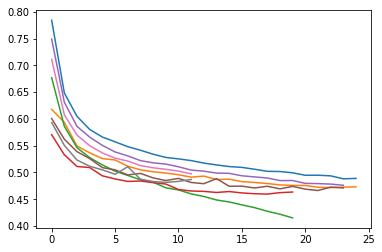

In [59]:
# generate and train a model
num_recurrent=32
num_runs = 10
early_stopping = EarlyStopping(monitor='val_loss',patience = 2, restore_best_weights=False)

print(f'baseline accuracy is: {1-np.mean(y_train[:40000])}')

for run in range(num_runs):
    
    # randomly select parameters in the specified ranges
    drop = np.random.uniform(low = drops_to_test[0],high=drops_to_test[1])
    num_dense = np.random.randint(low = num_dense_to_test[0],high  = num_dense_to_test[1])
    depth = np.random.choice(depth_to_test)
    batch_size = np.random.randint(low = batch_size_to_test[0],high = batch_size_to_test[1])

    # Report the conditions so we can track performance as we go
    print(f'Run number {run}:')
    print(f'Training model with {num_dense} dense units')
    print(f'Training model with dropout at {drop*100}%')
    print(f'Training model with batch size {batch_size}')
    print(f'Training model with depth {depth}')

    # Time the computation
    start = time.time()

    # Generate a model with the specified parameters
    model = generate_model(num_recurrent = num_recurrent,drop_prob=drop,num_dense=num_dense,depth=depth)
#     model.summary()

    # Fit the model
    history = model.fit(x=[x_train_encoded[:40000,:]],
                  y=y_train[:40000],
                  batch_size=batch_size,
                  epochs=30,
                  shuffle=True,
                  validation_data = ([x_val_encoded],y_val),
                  callbacks=[early_stopping],
                  verbose=1,
                 )

    # Calculate the run time
    end = time.time()
    
    # Save the results
    random_search_results = random_search_results.append(  
                                    {'dropout': drop,
                                    'num_dense': num_dense,
                                    'batch_size':batch_size,
                                    'depth':depth,
                                    'run_time_m':(end - start)/60,
                                    'min_val_loss':min(history.history["val_loss"]),
                                    'val_loss':history.history["val_loss"],
                                    'val_acc':history.history["val_acc"],
                                    'train_loss':history.history["loss"],
                                    'train_acc':history.history["acc"],
                                   },ignore_index=True)
    
    # Report the results
    print(f'With drop probability = {drop}')
    print(f'minimum val loss is {min(history.history["val_loss"])}')
    print(f'maximum val accuracy is {max(history.history["val_acc"])}')
    print(f'Run time = {(end - start)/60} mins')
    print('')
    print('')
    
    # Plot the performance
    plt.plot(history.history['loss'],'b')
    plt.plot(history.history['val_loss'],'r')

In [60]:
random_search_results.head(10)

,dropout,num_dense,batch_size,depth,run_time_m,min_val_loss,val_loss,val_acc,train_loss,train_acc
0,0.427168,15.0,83.0,2.0,24.024170,0.468042,"[0.6102870684721904, 0.5529747064935774, 0.528...","[0.6525374303879544, 0.6871475767943267, 0.704...","[0.7066168329834938, 0.6172136186137795, 0.574...","[0.5954999983131886, 0.6508999999970198, 0.672..."
1,0.441693,93.0,122.0,2.0,21.104634,0.466434,"[0.5993144478219367, 0.5714199955410562, 0.542...","[0.6533151845419288, 0.6556484534620844, 0.688...","[0.7352322915673256, 0.627588625767827, 0.5866...","[0.5877249967232346, 0.6322499973863364, 0.651..."
2,0.390785,49.0,124.0,2.0,21.919825,0.468365,"[0.6015449217871055, 0.5520487543722082, 0.527...","[0.6589539157794928, 0.6835504535939845, 0.714...","[0.7372428162038326, 0.626137675267458, 0.5769...","[0.5895250008285046, 0.6353500008821488, 0.669..."
3,0.281324,13.0,102.0,2.0,20.172515,0.464598,"[0.5852318999833596, 0.5403261406572788, 0.518...","[0.6656620686049131, 0.6913280217373577, 0.716...","[0.6914529414564371, 0.5893429758682847, 0.559...","[0.5996250077471137, 0.6550250051259995, 0.679..."
4,0.407341,77.0,124.0,2.0,20.105674,0.463545,"[0.5972372770494879, 0.5681544087078236, 0.528...","[0.6555512343286518, 0.663231576170505, 0.7109...","[0.7222352611243725, 0.6256702508509159, 0.582...","[0.5879999999016523, 0.6356750015676021, 0.656..."
5,0.270300,86.0,113.0,2.0,11.266824,0.472430,"[0.5776328914868514, 0.5288167593603396, 0.513...","[0.6544818146067001, 0.699008359708328, 0.7165...","[0.6672435186088085, 0.5774091209918261, 0.546...","[0.615624997176975, 0.6612749993771314, 0.6942..."
6,0.479302,31.0,94.0,2.0,28.435869,0.471731,"[0.6177181589529251, 0.5935039280303693, 0.549...","[0.6540929295894772, 0.6597316607111464, 0.684...","[0.7841613159656524, 0.6482704216629267, 0.604...","[0.5804999904185534, 0.6289999852061272, 0.649..."
7,0.256976,81.0,120.0,2.0,20.013219,0.459656,"[0.5705275721826281, 0.5330134877406645, 0.511...","[0.6636204509310469, 0.7062998222465671, 0.727...","[0.6768223298192024, 0.5861789566874505, 0.546...","[0.6120249988138675, 0.6578750003576279, 0.699..."
8,0.430666,21.0,118.0,2.0,24.431202,0.466333,"[0.6006294494180069, 0.5620435356989506, 0.538...","[0.6555512391730502, 0.6712035789184712, 0.693...","[0.7489323770582675, 0.6310937543481588, 0.585...","[0.5782750015482306, 0.632350002592802, 0.6570..."
9,0.427176,83.0,67.0,2.0,17.440702,0.481440,"[0.5932232545069074, 0.5505450653434147, 0.523...","[0.6576900664016521, 0.6757728954262476, 0.711...","[0.7109468399837613, 0.6075833718843758, 0.569...","[0.5945250019513071, 0.643500000269711, 0.6743..."


In [73]:
random_search_results.corr()['run_time_m']

dropout         0.651033
num_dense      -0.623444
batch_size     -0.067472
depth                NaN
run_time_m      1.000000
min_val_loss   -0.218098
Name: run_time_m, dtype: float64

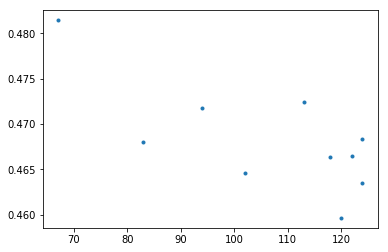

In [69]:
plt.plot(random_search_results.batch_size,random_search_results.min_val_loss,'.')

# Attention network
I'm curious to try implementing attention in my network. At a high level, attention infers which words are "important" for the computation, and up-regulates how much it uses those words in its computation. Similarly, it down-regulates how much it uses unimportant words in its computation. I'm referencing a number of different sources to figure out how to implement attention. Particularly useful are the discussion [here](https://github.com/keras-team/keras/issues/4962), [this paper](https://aclweb.org/anthology/N16-1174), and [this blog post](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#summary).

Interestingly, I found that quite a complex attention calculation seemed to work very well for me: Instead of doing a simple dense calculation on the inputs, adding a few convolutional layers before calculating the final attention weights really boosted performance. Not sure what the intuition here is necessarily, except that the relationship between which words are and are not important may be quite nonlinear, so having some convolutions in there helps the model to select the correct spots to attend to.

In [233]:
# support function to add attention weighting over time to a given times x units array
def add_attention(x,drop_prob):
    # Attention layer (closely based on: https://github.com/keras-team/keras/issues/4962#issuecomment-271934502)
    x = keras.layers.SpatialDropout1D(drop_prob)(x) # dropout random dimensions of the model
    x_red = Conv1D(4,kernel_size=1,strides=1,padding='same',activation='relu')(x) # reduce dimensionality to calculate attention faster        
    attention = keras.layers.Conv1D(1,kernel_size=3,strides=1,padding='same')(x) # this is the initial attention vector (not scaled)
    attention = keras.layers.Flatten()(attention) # size: (batch_size,n_times,1) -> (batch_size,n_times)
    attention = keras.layers.Activation('softmax',name='Attention')(attention) # Converts attention to a probability
    attention = keras.layers.RepeatVector(num_recurrent*2)(attention)
    attention = keras.layers.Permute([2, 1])(attention)

    # Output of the GRU is now weighted by the attention
    x = keras.layers.Multiply()([x,attention])
    
    # finally, take a sum of all of the values across time, weighted by attention
    x = keras.layers.pooling.GlobalAveragePooling1D()(x) # kind of a hack, scale issues counteracted by batch norm
    x = BatchNormalization()(x)
    
    return x

# Model architecture
def generate_attention_model(num_recurrent=64,drop_prob=.2):

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1],
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=None,
                                trainable=False)

    # This is a layer to take only the final state of a GRU network output that has been set to return sequences
    Slice_layer = Lambda(lambda x: K.squeeze(K.slice(x, [0,49,0],[K.shape(x1)[0],1,num_recurrent*2]),axis=1))


    # This is where the model input is specified: encoded inputs of MAX_SEQUENCE_LENGTH timepoints
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,),
                           dtype='int32')

    # Next, embed the input
    x1 = embedding_layer(sequence_input)   
    x1 = keras.layers.SpatialDropout1D(drop_prob)(x1) # dropout random dimensions of the embedding

    # Use a GRU to encode the input
    x1 = Bidirectional(GRU(num_recurrent,
             return_sequences=True,
            ))(x1)
    x1 = keras.layers.SpatialDropout1D(drop_prob)(x1) # dropout random dimensions of the model
    x = add_attention(x1,drop_prob) # Calculate attention weights

    # Finally, the output is a single unit whose output should be the estimated probability of the line being funny
    #     x1 = Flatten()(x1)

    preds = Dense(1, activation='sigmoid')(x)

    # This line specifies and compiles the model
    model = Model(inputs=[sequence_input], outputs=[preds])
    model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
              metrics=['acc'])

    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 50, 200)      4000200     input_36[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_93 (SpatialDr (None, 50, 200)      0           embedding_36[0][0]               
__________________________________________________________________________________________________
bidirectional_62 (Bidirectional (None, 50, 64)       44736       spatial_dropout1d_93[0][0]       
__________________________________________________________________________________________________
spatial_dr

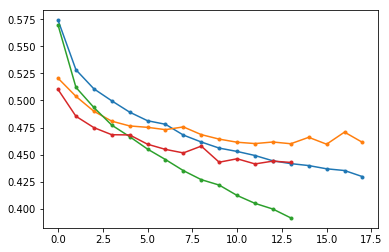

In [234]:
num_recurrent=32
drop_prob = 0.4
early_stopping = EarlyStopping(monitor='val_loss',patience = 2, restore_best_weights=True)

model = generate_attention_model(num_recurrent=num_recurrent,drop_prob = drop_prob)
model.summary()
start = time.time()
history = model.fit(x=[x_train_encoded],
              y=y_train,
              batch_size=64,
              epochs=30,
              shuffle=True,
              validation_data = ([x_val_encoded],y_val),
              callbacks=[early_stopping],
              verbose=1,
             )
end = time.time()
print(f'Run time is {(end-start)/60} mins')
print(f'Model validation loss is {model.evaluate([x_val_encoded],y_val)[0]}')

# Plot the performance
plt.plot(history.history['loss'],'.-')
plt.plot(history.history['val_loss'],'.-')
plt.plot(best_attn_history.history['loss'],'.-')
plt.plot(best_attn_history.history['val_loss'],'.-')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 50, 200)      4000200     input_17[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_59 (SpatialDr (None, 50, 200)      0           embedding_17[0][0]               
__________________________________________________________________________________________________
bidirectional_43 (Bidirectional (None, 50, 128)      101760      spatial_dropout1d_59[0][0]       
__________________________________________________________________________________________________
spatial_dr

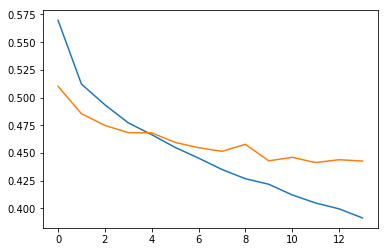

In [74]:
best_attn_model = model
best_attn_history = history
best_attn_model.summary()
print(f'Best attention model validation loss is {best_attn_model.evaluate([x_val_encoded],y_val)[0]*100}')
plt.plot(best_attn_history.history['loss'])
plt.plot(best_attn_history.history['val_loss'])

### Visualizing attention
We can plot the activations of the attention layer to see what the attention network is looking at while making its funny/not funny decisions. Hopefully, this will be something interpretable. 

In [209]:
# Function which runs the model up to the attention layer, then outputs the activation of that layer
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
Attn_output = K.function([model.layers[0].input],[model.get_layer('Attention').output])

def Plot_Validation_attention(val_idx):
    # Get the output of the attention layer
    attn = Attn_output([x_val_encoded[val_idx:val_idx+1,:]])[0][0]
    
    # Get whether the line was funny, and whether the model thought the line was funny
    prediction = model.predict([x_val_encoded[val_idx:val_idx+1,:]])
    true_y = y_val[val_idx]
    
    # Generate the figure
    plt.figure(figsize=(15,5))
    plt.plot(attn)
#     plt.ylim([0,.5])
    for i,word in enumerate(x_val[val_idx].split()[::-1]):
        plt.text(49-i,attn[49-i],word,horizontalalignment='center')
        
    # For a title, say the answer and whether the model predicted it correctly
    if true_y:
        plt.title(f'Model prediction {100*(prediction[0][0])//1}% chance funny (actual: FUNNY)')
    else:
        plt.title(f'Model prediction {100*(prediction[0][0])//1}% chance funny (actual: NOT funny)')

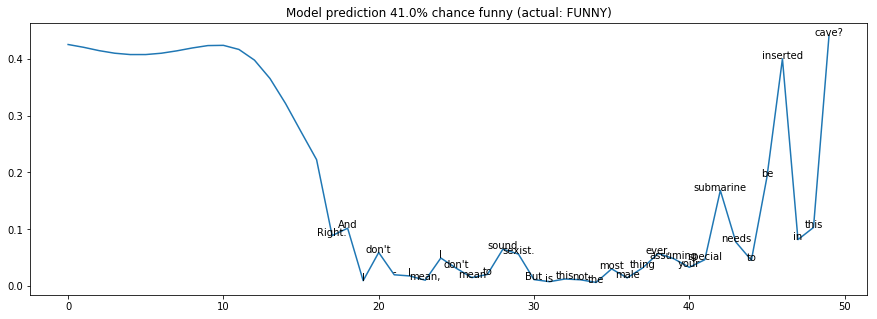

In [210]:
Plot_Validation_attention(818)

# Augmenting the data: synonyms
In training my models so far, I'm definitely struggling with the problem of over-fitting: the model starts to "memorize" the training data, and thus performs poorly on the validation data. I can try to combat this in a few ways: regularizing the model, via dropout or imposed loss functions on the weights. Another powerful method is to generate more training data. Since my training data currently includes 10 years' worth of transcripts (and the years prior to this don't have transcripts), I'm unlikely to be able to get "new" transcripts to help train on.

Instead, I will be trying a form of text regularization: I will replace some of the words in each sentence with synonyms. This will ahve the effect of slightly changing the phrasing of many sentences, without dramatically altering the meaning. I can then learn on both the original sentences and the "altered" sentences, essentially doubling (or more) my training set. Code for replacing words with synonyms is based on this tutorial: http://rwet.decontextualize.com/book/textblob/

In [260]:
from textblob import TextBlob

# Function to replace a dataset with synonyms. 
# This function will be performed num_samples times, so if I want to make 3 new sentences for every 1 input sentence,
# then num_samples should be 3
def Augment_training_set(x_train,y_train,num_samples=1,p=0.5):
    
    # Use a dictionary of positions, to specify what part of speech a word is being used as and select better synonyms
    pos_dict = {'NN':'n','NNS':'n','NNP':'n','NNPS':'n' ,
               'VB':'v', 'VBD':'v','VBG':'v','VBN':'v','VBP':'v','VBZ':'v',
               'JJ':'a','JJR':'a','JJS':'a','RB':'r','RBR':'r','RBS':'r'} # part of speech dictionary
    part_of_speech_list = pos_dict.keys()
    
    # initialize the augmented outputs
    y_augmented = y_train
    x_augmented = x_train
    
    # For each line, with some probability, switch up nouns, verbs, adjectives, and adverbs with synonyms
    for sample in range(num_samples):
        x_syn = Replace_synonyms(x_train,p)
        
        # combine the initial dataset and the new datasets together
        x_augmented = np.concatenate((x_augmented,x_syn))
        y_augmented = np.concatenate((y_augmented,y_train))
        
    # Finally, re-calculate the encoding so that we can feed the new sentences into our models
    x_train_augmented_encoded,x_val_encoded,word_index = Encode_lines(x_augmented,x_val)
    embedding_matrix = Make_embedding_matrix(word_index)
    
    return x_augmented,x_train_augmented_encoded,y_augmented,x_val_encoded,embedding_matrix

# Helper function for Augment training set: replace words in x_train with synonyms with specified probability
def Replace_synonyms(x,p=0.5):
    
    for idx,line in enumerate(x):

        # Use TextBlob to identify words + part of speech
        blob = TextBlob(line)
        output = list()

        # Replace nouns, verbs, adjectives, and adverbs with synonyms (with specified probability)
        for word,tag in blob.tags:
            if (len(word) > 4) and (tag in part_of_speech_list) and len(word.get_synsets(pos=pos_dict[tag])) > 0:
                if np.random.rand() >p:
                    random_synset = np.random.choice(word.get_synsets(pos=pos_dict[tag]))
                    random_lemma = np.random.choice(random_synset.lemma_names())
                    output.append(random_lemma.replace('_', ' '))
            else:
                output.append(word)
        x_syn[idx] = ' '.join(output)
        if idx%10000 == 0:
            print(f'Completed line {idx}.')
    return x_syn

In [261]:
x_augmented,x_train_augmented_encoded,y_augmented,x_val_encoded,embedding_matrix = Augment_training_set(x_train,y_train,num_samples=3)



NameError: name 'part_of_speech_list' is not defined

# Trying some gradient boosted trees

In [414]:
# make an embedding model
embedding_layer = Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=None,
                        trainable=False)

# GRU to process the words
sequence_input = Input(shape=(None,), dtype='int32')

x1 = embedding_layer(sequence_input)   

embedding_model = Model(inputs=[sequence_input], outputs=[x1])
embedding_model.compile(loss='binary_crossentropy',
              optimizer='Adam')

In [415]:
x_train_embedded = embedding_model.predict(x_train_encoded)
x_val_embedded = embedding_model.predict(x_val_encoded)

In [481]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()
clf = ExtraTreesClassifier(n_estimators=10)

# Build the pipeline
pipeline = Pipeline([
#     ('pca',pca),
    ('rf',clf),
    ])


In [482]:
duration = 25
pipeline.fit(
    X = x_train_embedded[:,-duration:,:].reshape(x_train_embedded.shape[0],duration*200),
    y = y_train.astype(int)
    )
pipeline.score(x_val_embedded[:,-duration:,:].reshape(x_val_embedded.shape[0],duration*200),
          y_val.astype(int))

0.7413385826771653

In [486]:
x_pred_forest = pipeline.predict(x_val_embedded[:,-duration:,:].reshape(x_val_embedded.shape[0],duration*200))
x_pred_gru = model.predict(x_val_encoded)

In [506]:
combined_pred = (x_pred_forest*.25 + x_pred_gru.reshape(-1)*.75)>.5

In [507]:
sum(combined_pred==y_val)/y_val.shape

array([0.74724409])

# Generate a transcript

In [682]:
# character-level tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(train_transcript_df.transcript)

In [684]:
# test an example transcript into and out of the tokens
sequence = tokenizer.texts_to_sequences(train_transcript_df.transcript[1])
' '.join(tokenizer.sequences_to_texts(sequence[:300]))

"                         B I L L  K U R T I S   F r o m  N P R  a n   W B E Z  C h i c a g o   t h i s  i s  W A I T  W A I T     D O N ' T  T E L L  M E   t h e  N P R  n e  s   u i    H e y   A r t h u r  M i l l e r    s t e p  i n t o  t h i s  C r u c i  B i l l   p h         L A U G H T E R       K U R T I S   I ' m  B i l l  K u r t i s   A n   h e r e ' s  y o u r  h o s t  a t  t h e  C h a s e  B a n k  A u  i t o r i u m  i n   o  n t o  n  C h i c a g o   P e t e r  S a g a l "

In [670]:
# Divide the transcripts into overlapping phrases to train on
phrase_length = 200
num_chars = len(tokenizer.word_counts)
step_size = 10

def Make_sequences(train_transcript_df,phrase_length = phrase_length, step_size = step_size):
    # encode all texts
    sequences = tokenizer.texts_to_sequences(train_transcript_df.transcript)
    
    # Divide into overlapping chunks
    num_chunks = np.sum(1+(train_transcript_df.transcript.str.len()-phrase_length)//step_size)
    x = np.zeros((num_chunks,phrase_length))
    y = np.zeros((num_chunks,num_chars)) # y will be one hot encoded
    idx = 0
    for sequence in sequences:
        for start_pos in range(0,len(sequence)-phrase_length,step_size):
            x[idx,:] = sequence[start_pos:(start_pos+phrase_length)]
            y[idx,sequence[start_pos+phrase_length]] = 1
            idx +=1
    return x,y

In [677]:
x_train,y_train = Make_sequences(train_transcript_df)

In [678]:
# design a proof-of-concept model
model = keras.models.Sequential()
model.add(Embedding(num_chars,64,input_length=phrase_length))
model.add(GRU(64))
model.add(Dense(num_chars,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_106 (Embedding)    (None, 200, 64)           6720      
_________________________________________________________________
gru_87 (GRU)                 (None, 64)                24768     
_________________________________________________________________
dense_253 (Dense)            (None, 105)               6825      
Total params: 38,313
Trainable params: 38,313
Non-trainable params: 0
_________________________________________________________________


In [681]:
batch_size = 128
start=time.time()
history = model.fit(x=x_train,
              y=y_train,
              batch_size=batch_size,
              epochs=1,
              shuffle=True,
              validation_split = 0.2,
              callbacks=[early_stopping],
              verbose=1,
             )

end = time.time()
print(f'minimum val loss is {min(history.history["val_loss"])}')
print(f'maximum val accuracy is {max(history.history["val_acc"])}')
print(f'Run time = {(end - start)/60} mins')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Evaluate_model(model)

Train on 1926361 samples, validate on 481591 samples
Epoch 1/1
  93824/1926361 [>.............................] - ETA: 42:41 - loss: 2.5716

KeyboardInterrupt: 